In [1]:
import numpy as np
import pandas as pd
from pandas import read_csv
from datetime import datetime
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib
import matplotlib.pyplot as plt
import math

ModuleNotFoundError: No module named 'statsmodels'

In [18]:
date_parser = lambda d: datetime.strptime(d, '%Y%m')

# Read Dataset from CSV into Pandas Dataframe.
indexed_data_df = read_csv(
    '../../data/data.csv',
    names=['date', 'temperature'],
    dtype={'date': 'str', 'temperature': 'float'},
    parse_dates=['date'],
    date_parser=date_parser,
    index_col='date'
)

data_df = read_csv(
    '../../data/data.csv',
    names=['date', 'temperature'],
    dtype={'date': 'str', 'temperature': 'float'},
    parse_dates=['date'],
    date_parser=date_parser
)
np_data = np.array([[np.datetime64(d), t] for d, t in data_df.to_numpy()])
for d, t in np_data:
    if not type(d) == type(np_data[0][0]):
        print(type(d))

In [19]:
# Isolate dataset trend only and save it as a numpy array
decompose_res = seasonal_decompose(indexed_data_df, model='additive', freq=12)
trend_data_np = np.array([[d, round(t, 5)] for d, t in zip(data_df['date'].to_numpy(), decompose_res.trend) if not math.isnan(t)])
print(trend_data_np)

[[numpy.datetime64('1880-07-01T00:00:00.000000000') -0.12625]
 [numpy.datetime64('1880-08-01T00:00:00.000000000') -0.12375]
 [numpy.datetime64('1880-09-01T00:00:00.000000000') -0.11375]
 ...
 [numpy.datetime64('2019-12-01T00:00:00.000000000') 1.01125]
 [numpy.datetime64('2020-01-01T00:00:00.000000000') 1.00917]
 [numpy.datetime64('2020-02-01T00:00:00.000000000') 1.00917]]


In [41]:
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

X = trend_data_np[:,0].reshape((-1, 1))
y = trend_data_np[:,1].reshape((-1, 1))

sc_X = StandardScaler()
sc_y = StandardScaler()

normalized_X = sc_X.fit_transform(X)
normalized_y = sc_y.fit_transform(y)

svr_model = SVR(kernel='rbf')

# parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10]}
# clf = GridSearchCV(svr_model, parameters)
# clf.fit(trend_data_np[:,0].reshape((-1, 1)), trend_data_np[:,1])

svr_model.fit(normalized_X, normalized_y)

SVR()

In [42]:
from datetime import date
from dateutil import relativedelta

# Generate Future Dates
np_future_dates = []
curr_date = datetime.strptime('01-1880', '%m-%Y').replace(day=1, hour=0, minute=0, second=0, microsecond=0)
while curr_date <= datetime.strptime('01-2050', '%m-%Y'):
    curr_date += relativedelta.relativedelta(months=1)
    curr_date.replace(day=1, hour=0, minute=0, second=0, microsecond=0)
    np_future_dates.append(np.datetime64(curr_date))
np_future_dates = sc_X.transform(np.array(np_future_dates))

future_predicted_values = svr_model.predict(np_future_dates.reshape((-1, 1)))
print(future_predicted_values)

[0.64975088 0.64975088 0.64975088 ... 0.64975088 0.64975088 0.64975088]


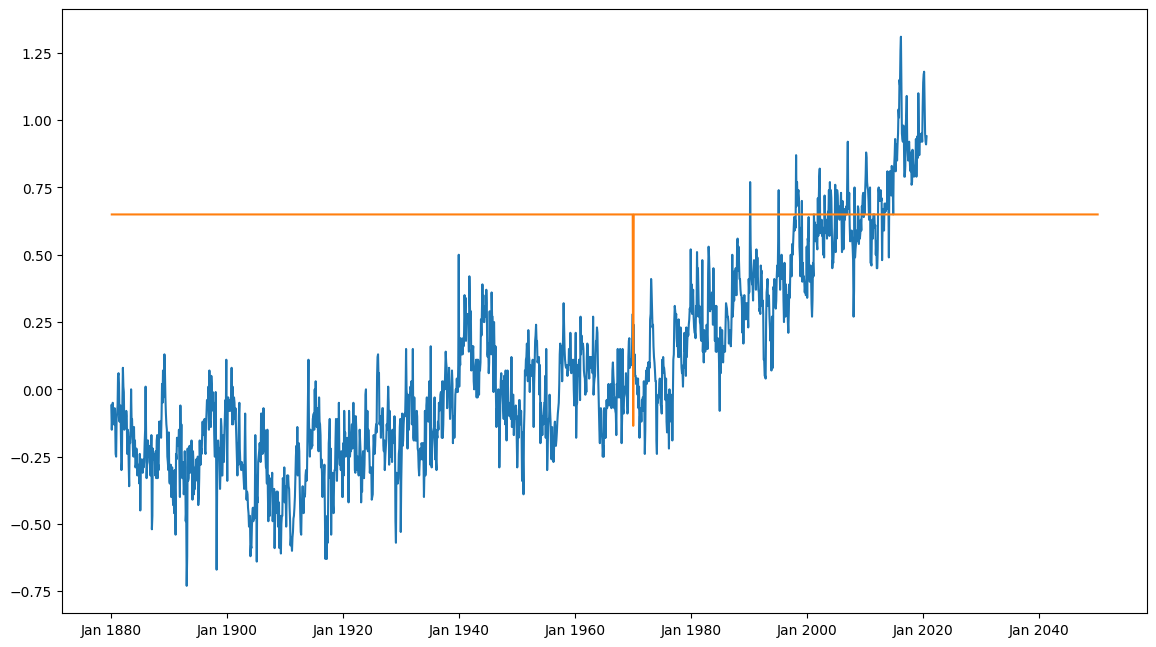

In [43]:
# Graph prediction with observed data
fig = plt.figure(figsize=(14, 8), dpi=100, facecolor='w', edgecolor='k')
sub_plot = fig.add_subplot(1,1,1)
sub_plot.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%b %Y'))
sub_plot.plot(np_data[:,0], np_data[:,1])
sub_plot.plot(np_future_dates, future_predicted_values)
plt.show()